#Advanced Machine Learning and predictions on full COSMOS Optical data

#####Import Packages

In [ ]:
#!pip install delayed
#!pip install mljar-supervised
from supervised.automl import AutoML

In [ ]:
# Common imports
import numpy as np
import pandas as pd
import sklearn.metrics
#from sklearn.datasets import make_classification
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
# to make this notebook's output stable across runs
np.random.seed(40)

#import modin.pandas as pd #a faster version of pandas that runs on multiple cores

#import scipy as sp
from astropy.table import Table #to read the .FITS file
#from tqdm.notebook import tqdm 
num=0
from google.colab import drive
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
#pd.set_option('use_inf_as_na', True)

#Machine learning on COSMOS Optical counterparts to the Herschel-VLA data within s threshold of 95% purity

###Optical Dataset 95% purity
Cosmos dataset matched with VLA Radio data positions

In [ ]:
#mounts the google drive to save time
drive.mount('/content/drive')
#changes to the needed directory
os.chdir('/content/drive/MyDrive/Herschel/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# HOR (Herschel Optical Radio Counterparts)
from astropy.table import Table #to read the .FITS file

df_95_purity = Table.read(f'all_opitical_matched_to_95_purity_radio.fits', format='fits').to_pandas()
df_95_purity.drop('col1',axis=1,inplace=True) #remove null columns
df_95_purity = df_95_purity.rename(columns={'F_BLIND_MF_SPIRE_250': 'H_250_flux','F_BLIND_MF_SPIRE_350': 'H_350_flux','F_BLIND_MF_SPIRE_500': 'H_500_flux','flux_match':'Radio_flux'})

##ML Preprocessing for threshold at 95% purity

In [ ]:
df_95_purity_SED = df_95_purity[['Radio_flux','MFUV', 'MNUV', 'MU', 'MG', 'MR', 'MI', 'MZ', 'MY', 'MJ', 'MH', 'MK']] #Select features
df_95_purity_SED['Radio_flux'].fillna(0,inplace=True) #Fill NaN values as 0 radio flux
df_95_purity_SED['Counterpart'] = np.where(df_95_purity_SED['Radio_flux']!= 0, True, False) #Label sources matched with radio data as 'True' and sources with no radio flux as 'False'
df_95_purity_SED  = df_95_purity_SED.replace([999, -999], np.nan).dropna().drop('Radio_flux', 1) #Drop missing values

In [ ]:
#Split dataframe for sources with and without a counterpart
dftrue = df_95_purity_SED[df_95_purity_SED['Counterpart'] == True]
dffalse = df_95_purity_SED[df_95_purity_SED['Counterpart'] == False] 

In [ ]:
#Random sample of sources with no counterpart
dffalse1 = dffalse.sample(n = 3318, replace = False,random_state = 42)
dffalse3 = dffalse.sample(n = 60000, replace = False,random_state = 42)
frames1 = [dftrue, dffalse1]
frames2 = [dftrue, dffalse]
frames3 = [dftrue, dffalse3]

df1 = pd.concat(frames1)
df2 = pd.concat(frames2)
df3 = pd.concat(frames3)

In [ ]:
#Balanced Dataset 3318 each
df_x1 = df1.drop('Counterpart',axis=1)
df_y1 = df1['Counterpart']

#split the data into training and test data sets

train_x1, test_x1, train_y1, test_y1 = train_test_split(df_x1, df_y1, test_size=0.2, random_state=40,stratify=df_y1)

#Full dataset, ~1700000 False and 3318 True
df_x2 = df2.drop('Counterpart',axis=1)
df_y2 = df2['Counterpart']

#split the data into training and test data sets

train_x2, test_x2, train_y2, test_y2 = train_test_split(df_x2, df_y2, test_size=0.2, random_state=40)

#Unbalanced Dataset False:True, 20:1
df_x3 = df3.drop('Counterpart',axis=1)
df_y3 = df3['Counterpart']

#split the data into training and test data sets

train_x3, test_x3, train_y3, test_y3 = train_test_split(df_x3, df_y3, test_size=0.2, random_state=40)

##Train ML models for data at 95% purity

##Training and prediction usingthe full COSMOS dataset
We trained and predicted using the full COSMOS dataset to analyse how well the machine would respond to a highly unbalanced dataset.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
#training and prediction using Decision Tree Classifier
tree=DecisionTreeClassifier(random_state=40,max_depth=10,max_leaf_nodes=25)
#Train and predict dataset to get scores
tree.fit(train_x2,train_y2)
y_pred2 = tree.predict(test_x2)

print(round(accuracy_score(test_y2, y_pred2),4))
print('     Neg   Pos')
print('Neg',confusion_matrix(test_y2,y_pred2))
print(classification_report(test_y2,y_pred2))

0.998
     Neg   Pos
Neg [[340418      3]
 [   663      0]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    340421
        True       0.00      0.00      0.00       663

    accuracy                           1.00    341084
   macro avg       0.50      0.50      0.50    341084
weighted avg       1.00      1.00      1.00    341084



###LightGBM for full COSMOS dataset

In [ ]:
import lightgbm as lgb

In [ ]:
#training and prediction using LightGBM classifier

#train_x1, test_x1, train_y1, test_y1

lgb_train = lgb.Dataset(train_x2, train_y2)

lgb_eval = lgb.Dataset(test_x2, test_y2, reference=lgb_train)

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}


gbm = lgb.train(params,
                train_set=lgb_train,
               
                num_boost_round=300,
                valid_sets=lgb_eval,
                early_stopping_rounds=150
                )

lgbm_y_pred = gbm.predict(test_x2, num_iteration=gbm.best_iteration)


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
print('The rmse of prediction is:', mean_squared_error(test_y2, lgbm_y_pred)**0.5)

print('Log loss of LightGBM: {:6f}'.format(log_loss( test_y2, lgbm_y_pred)) )

The rmse of prediction is: 0.04238207337900096
Log loss of LightGBM: 0.008802


LightGBM prediction on 95% purity data <br>
The LGBM, rmse prediction is: 0.20033152678359858 <br>
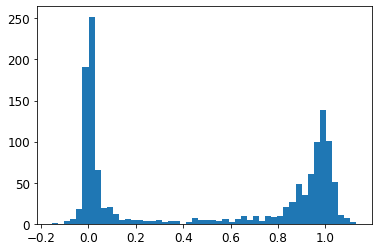
<br>

LightGBM predictions on 95% data with Removed Outliers <br>

The LGBM, rmse prediction is: 0.2300844283113034 <br>
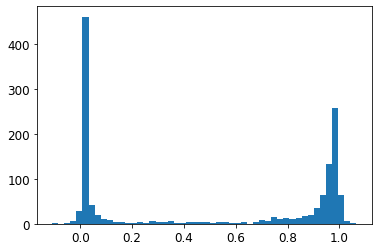

LightGBM prediction on the full COSMOS dataset <br>
The LGBM, rmse prediction is: 0.04238207337900096 <br>
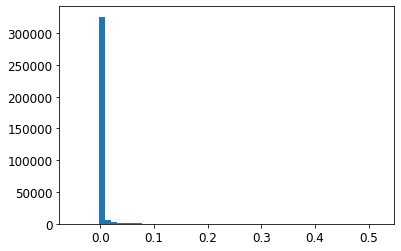
<br> 



In [ ]:
predict = lgbm_y_pred
plt.hist(predict,bins=50)

#Predictions of Submm sources using best trained model

In [ ]:
from sklearn.metrics import precision_score
def pos_precision(y_true, y_predicted,sample_weight=None):
    # asure proper type
    if isinstance(y_true, pd.DataFrame):
        y_true = np.array(y_true)
    if isinstance(y_predicted, pd.DataFrame):
        y_predicted = np.array(y_predicted)

    if len(y_predicted.shape) == 2 and y_predicted.shape[1] == 1:
        y_predicted = y_predicted.ravel()

    # cast to integer
    if len(y_predicted.shape) == 1:
        y_predicted = (y_predicted > 0.5).astype(int)
    else:
        y_predicted = np.argmax(y_predicted, axis=1)

    val = precision_score(y_true, y_predicted, sample_weight=sample_weight,)
    return -val

###AutoML LightGBM training and prediction on full COSMOS dataset using custom positive precision metric

AutoML directory: AutoML_custom_metric_LGBM
The task is binary_classification with evaluation metric user_defined_metric
AutoML will use algorithms: ['LightGBM']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_LightGBM user_defined_metric -0.178082 trained in 167.02 seconds
* Step ensemble will try to check up to 1 model
AutoML fit time: 821.41 seconds
AutoML best model: 1_Default_LightGBM


AutoML(algorithms=['LightGBM'],
       eval_metric=<function pos_precision at 0x7f5aa71c4b00>,
       results_path='AutoML_custom_metric_LGBM')

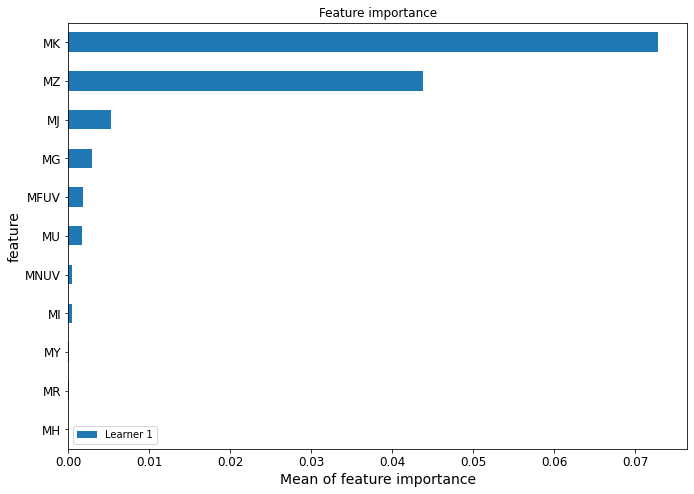

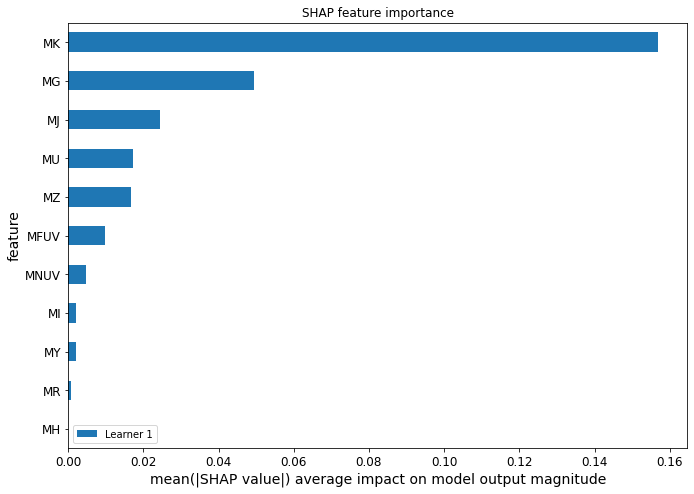

In [ ]:
#AutoML LightGBM training and prediction on full COSMOS dataset using custom positive precision metric
automl_metric = AutoML(results_path="AutoML_custom_metric_LGBM", eval_metric = pos_precision, algorithms=['LightGBM'])
automl_metric.fit(train_x2, train_y2)  

-0.912104, -0.91342, -0.912104

In [ ]:
#Prediction on the training data
pred_train = automl_metric.predict(train_x1)
print(classification_report(train_y1, pred_train,digits=6))
confusion_matrix(train_y1, pred_train),precision_score(train_y1, pred_train)

              precision    recall  f1-score   support

       False   0.678507  0.986059  0.803870      2654
        True   0.974500  0.532781  0.688916      2654

    accuracy                       0.759420      5308
   macro avg   0.826503  0.759420  0.746393      5308
weighted avg   0.826503  0.759420  0.746393      5308



(array([[2617,   37],
        [1240, 1414]]), 0.974500344589938)

In [ ]:
#Prediction on the test data
pred_test = automl_metric.predict(test_x1)
print(classification_report(test_y1, pred_test,digits=6))
confusion_matrix(test_y1, pred_test),precision_score(test_y1, pred_test)

              precision    recall  f1-score   support

       False   0.684647  0.993976  0.810811       664
        True   0.989011  0.542169  0.700389       664

    accuracy                       0.768072      1328
   macro avg   0.836829  0.768072  0.755600      1328
weighted avg   0.836829  0.768072  0.755600      1328



(array([[660,   4],
        [304, 360]]), 0.989010989010989)

In [ ]:
df_x2 = df2.drop('Counterpart',axis=1)
df_y2 = df2['Counterpart']
pred = automl_metric.predict(df_x2)

In [ ]:
confusion_matrix(df_y2, pred)

array([[1676391,   25709],
       [   1544,    1774]])

In [ ]:
print(classification_report(df_y2, pred,digits=6))
precision_score(df_y2, pred)

              precision    recall  f1-score   support

       False   0.999179  0.987844  0.993480   1702100
        True   0.085606  0.583785  0.149316      3318

    accuracy                       0.987058   1705418
   macro avg   0.542393  0.785815  0.571398   1705418
weighted avg   0.997402  0.987058  0.991837   1705418



0.08560569231449154

In [ ]:
plt.hist(pred,bins=50)

###AutoML Ensemble Performance in training and prediction on 95% purity data using custom positive precision metric

In [ ]:
automl_perform = AutoML(results_path="AutoML_metric_perform_1",mode="Perform",golden_features=20,eval_metric = pos_precision,algorithms=['Neural Network','Random Forest','Nearest Neighbors','Linear','LightGBM'])
automl_perform.fit(train_x1, train_y1)  

AutoML directory: AutoML_metric_perform_1
The task is binary_classification with evaluation metric user_defined_metric
AutoML will use algorithms: ['Neural Network', 'Random Forest', 'Nearest Neighbors', 'Linear', 'LightGBM']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
* Step simple_algorithms will try to check up to 1 model
1_Linear user_defined_metric -0.92111 trained in 21.51 seconds (1-sample predict time 0.0649 seconds)
* Step default_algorithms will try to check up to 4 models
2_Default_LightGBM user_defined_metric -0.932378 trained in 22.16 seconds (1-sample predict time 0.0298 seconds)
3_Default_NeuralNetwork user_defined_metric -0.923077 trained in 18.26 seconds (1-sample predict time 0.0598 seconds)
4_Default_RandomForest user_defined_metric -0.926401 trained in 37.14 seconds (1-sample predict 

AutoML(algorithms=['Neural Network', 'Random Forest', 'Nearest Neighbors',
                   'Linear', 'LightGBM'],
       eval_metric=<function pos_precision at 0x7f9322171d40>,
       golden_features=20, mode='Perform',
       results_path='AutoML_metric_perform_1')

In [ ]:
df_x2 = df2.drop('Counterpart',axis=1)
df_y2 = df2['Counterpart']


In [ ]:
#Prediction on the COSMOS data
pred_metric = automl_perform.predict(df_x2)

confusion_matrix(df_y2, pred_metric)

array([[1574537,  127563],
       [    113,    3205]])

      [1568640,  133460]
      [     49,    3269]

Perform

      [1574537,  127563]
      [    113,    3205]

In [ ]:
print(classification_report(df_y2, pred_metric,digits=6))
precision_score(df_y2, pred_metric)

              precision    recall  f1-score   support

       False   0.999928  0.925056  0.961036   1702100
        True   0.024509  0.965943  0.047805      3318

    accuracy                       0.925135   1705418
   macro avg   0.512219  0.945499  0.504420   1705418
weighted avg   0.998030  0.925135  0.959259   1705418



0.024509054202863086

(array([1574650.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,  130768.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

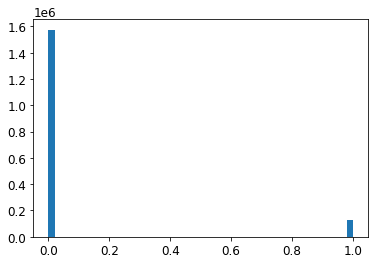

In [ ]:
plt.hist(pred_metric,bins=50)

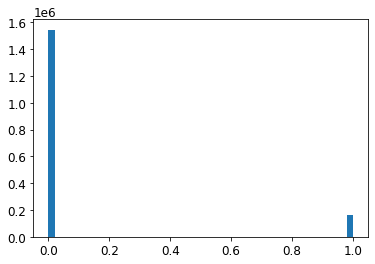

###AutoML Ensemble Compete training and prediction on 95% purity data using custom positive precision metric

AutoML directory: AutoML_metric_compete_6
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Random Forest', 'Neural Network', 'LightGBM']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree logloss 0.272074 trained in 19.72 seconds
Disable stacking for split validation
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 3 models


KeyboardInterrupt: ignored

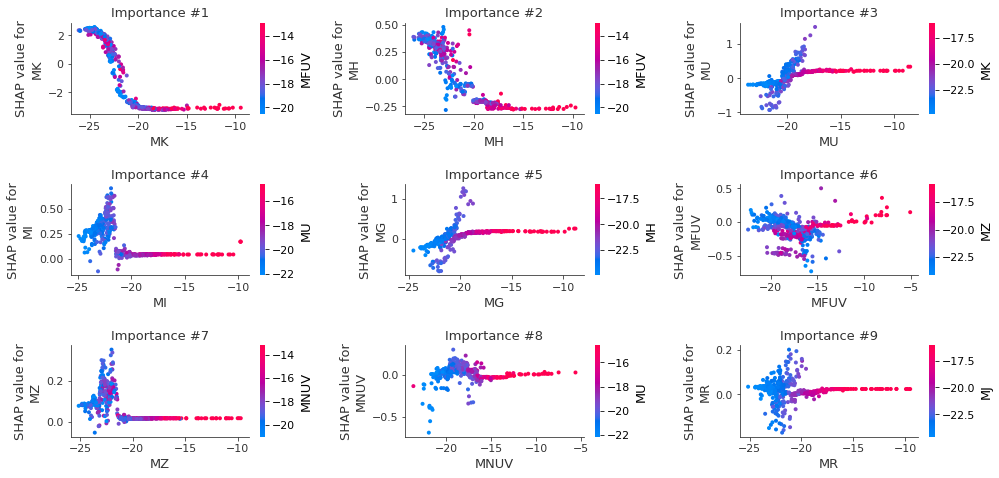

In [ ]:
#AutoML Ensemble Compete training and prediction on 95% purity data using custom positive precision metric
automl_compete_0 = AutoML(results_path="AutoML_metric_compete_6",mode="Compete",explain_level=2, eval_metric = pos_precision,algorithms=['Random Forest','Neural Network','LightGBM'])
automl_compete_0.fit(train_x1, train_y1)  

In [ ]:
df_x2 = df2.drop('Counterpart',axis=1)
df_y2 = df2['Counterpart']


In [ ]:
#del df2
pred6 = automl_compete.predict(df_x2)

confusion_matrix(df_y2, pred6)

array([[1544319,  157781],
       [     73,    3245]])

(array([1544392.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,  161026.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

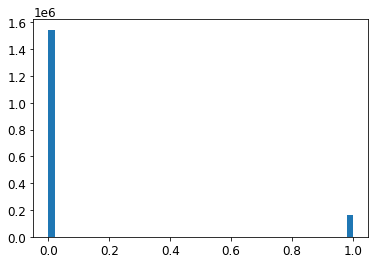

In [ ]:
plt.hist(pred6,bins=50)

###AutoML Neural Network and LightGBM Ensemble Compete training and prediction on 95% purity data using custom positive precision metric

In [ ]:
df_x2 = df2.drop('Counterpart',axis=1)
df_y2 = df2['Counterpart']

In [ ]:
#AutoML Neural Network and LightGBM Ensemble Compete training and prediction on 95% purity data using custom positive precision metric
automl_compete = AutoML(results_path="AutoML_29", mode="Compete",explain_level=2, eval_metric = 'logloss',algorithms=['LightGBM','Neural Network'])
automl_compete.fit(train_x1, train_y1)

In [ ]:
pred5 = automl_compete.predict(df_x2)

In [ ]:
print(confusion_matrix(df_y2, pred5))
accuracy_score(df_y2,pred5)

AutoML Results 1

      [1558869  143231]
      [     81    3237]
AutoML_26

    [1559743  142357]
    [    104    3214]

AutoML_33

    [1544319  157781]
    [     73    3245]

AutoML_30
    
    [1558869  143231]
    [     81    3237]]

AutoML_24

    [1562598  139502]
    [     71    3247]

AutoML_22

    [1568478  133622]
    [     84    3234]

AutoML_21
    
    [1576690  125410]
    [    152    3166]

In [ ]:
plt.hist(pred5,bins=50)